In [1]:
import numpy as np
import tensorflow as tf
import os
from tqdm import tqdm
import cv2

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for subdir in tqdm(os.listdir(directory)):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            label = subdir
            for filename in os.listdir(subdir_path):
                img_path = os.path.join(subdir_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                    images.append(np.array(img))
                    labels.append(label)
    return images, np.array(labels)

In [4]:
images, labels = load_images_from_directory(r"/kaggle/input/brain-tumor-mri-scans")

100%|██████████| 4/4 [00:58<00:00, 14.60s/it]


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=69
)


In [6]:
labels_dict = dict([tuple(reversed(i)) for i in tuple(enumerate(set(labels)))])
ld = dict(enumerate(set(labels)))
print(ld)
labels_dict

{0: 'pituitary', 1: 'meningioma', 2: 'glioma', 3: 'healthy'}


{'pituitary': 0, 'meningioma': 1, 'glioma': 2, 'healthy': 3}

In [7]:
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L2

In [8]:
base_model = EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = Conv2D(filters = 64, kernel_size = 3)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu", kernel_regularizer=L2(0.002))(x)
x = Dropout(0.05)(x)
x = Dense(64, activation="relu", kernel_regularizer=L2(0.002))(x)
x = Dropout(0.05)(x)
outputs = Dense(len(labels_dict), activation='softmax')(x)

In [10]:
model = Model(inputs, outputs)

In [11]:
def compile_and_fit_model(optimizer):
    global model
    model.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    history = model.fit(
    np.array(X_train),
    np.array([labels_dict[i] for i in y_train]), epochs=100,
                    validation_data=(np.array(X_test), np.array([labels_dict[i] for i in y_test])),
                    callbacks=[early_stopping]
    )
    return history

In [12]:
model = Model(inputs, outputs)

history = compile_and_fit_model("adam")

Epoch 1/100


I0000 00:00:1729324481.588177      98 service.cc:145] XLA service 0x7b4dc40014c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729324481.588243      98 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/176 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.3212 - loss: 1.8588  

I0000 00:00:1729324534.905802      98 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/176 ━━━━━━━━━━━━━━━━━━━━ 146s 427ms/step - accuracy: 0.7050 - loss: 1.0974 - val_accuracy: 0.9096 - val_loss: 0.4995
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8819 - loss: 0.5763 - val_accuracy: 0.9231 - val_loss: 0.4160
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.8983 - loss: 0.4927 - val_accuracy: 0.9260 - val_loss: 0.4121
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9021 - loss: 0.4618 - val_accuracy: 0.9438 - val_loss: 0.3251
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9204 - loss: 0.3887 - val_accuracy: 0.9317 - val_loss: 0.3430
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9229 - loss: 0.3732 - val_accuracy: 0.9488 - val_loss: 0.2875
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9354 - loss: 0.3203 - val_accuracy: 0.9359 - val_loss: 0.3201
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9276 - loss: 0.3099 - va

In [13]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 8, 8, 1536)     │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 6, 6, 64)       │       884,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,635,532 (59.64 MB)

 Trainable params: 901,636 (3.44 MB)

 Non-trainable params: 12,930,622 (49.33 MB)

 Optimizer params: 1,803,274 (6.88 MB)

In [14]:
history = history.history

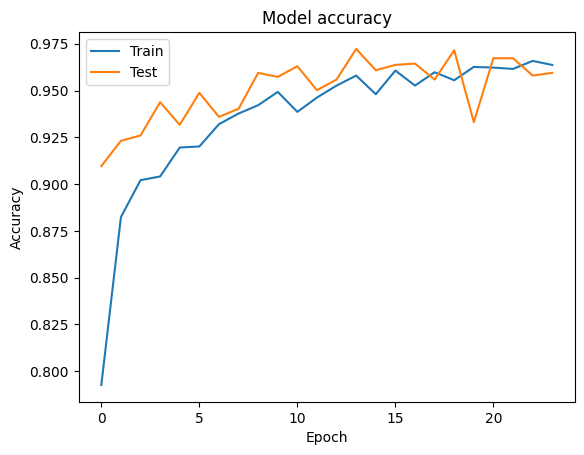

In [15]:
import matplotlib.pyplot as plt
plt.plot(np.array(history['accuracy']))
plt.plot(np.array(history['val_accuracy']))
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

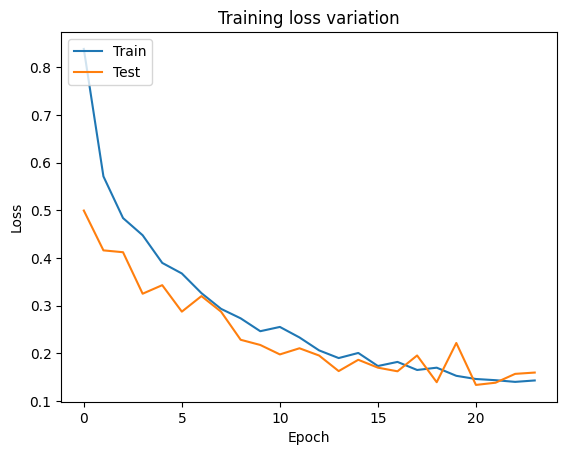

In [16]:
plt.plot(np.array(history["loss"]))
plt.plot(np.array(history["val_loss"]))
plt.title('Training loss variation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
history1 = compile_and_fit_model(tf.keras.optimizers.Adam(1e-5))

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 133s 377ms/step - accuracy: 0.9595 - loss: 0.1482 - val_accuracy: 0.9687 - val_loss: 0.1323
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9675 - loss: 0.1169 - val_accuracy: 0.9744 - val_loss: 0.1260
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9760 - loss: 0.1036 - val_accuracy: 0.9758 - val_loss: 0.1221
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9784 - loss: 0.0969 - val_accuracy: 0.9765 - val_loss: 0.1193
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.9796 - loss: 0.0949 - val_accuracy: 0.9758 - val_loss: 0.1184
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9778 - loss: 0.0987 - val_accuracy: 0.9758 - val_loss: 0.1168
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9790 - loss: 0.0959 - val_accuracy: 0.9765 - val_loss: 0.1156
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9844 - loss:

In [18]:
history2 = compile_and_fit_model(tf.keras.optimizers.Adam(1e-7))

Epoch 1/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 136s 393ms/step - accuracy: 0.9842 - loss: 0.0840 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9811 - loss: 0.0924 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9857 - loss: 0.0812 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - accuracy: 0.9780 - loss: 0.0952 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9835 - loss: 0.0853 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.9809 - loss: 0.0878 - val_accuracy: 0.9786 - val_loss: 0.1112
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9834 - loss: 0.0848 - val_accuracy: 0.9786 - val_loss: 0.1111
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.9823 - loss:

In [19]:
base_model.trainable = True
model.compile(optimizer= tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history4 = model.fit(
np.array(X_train),
np.array([labels_dict[i] for i in y_train]), epochs=100,
                    validation_data=(np.array(X_test), np.array([labels_dict[i] for i in y_test])),
                    callbacks=[early_stopping]
    )

Epoch 1/100


I0000 00:00:1729326046.931438      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_18', 232 bytes spill stores, 236 bytes spill loads



176/176 ━━━━━━━━━━━━━━━━━━━━ 328s 865ms/step - accuracy: 0.7714 - loss: 0.7695 - val_accuracy: 0.9018 - val_loss: 0.3388
Epoch 2/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.8860 - loss: 0.3576 - val_accuracy: 0.9367 - val_loss: 0.2498
Epoch 3/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9167 - loss: 0.2732 - val_accuracy: 0.9423 - val_loss: 0.2148
Epoch 4/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9355 - loss: 0.2180 - val_accuracy: 0.9488 - val_loss: 0.1889
Epoch 5/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9414 - loss: 0.1987 - val_accuracy: 0.9609 - val_loss: 0.1642
Epoch 6/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9400 - loss: 0.2010 - val_accuracy: 0.9594 - val_loss: 0.1601
Epoch 7/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9572 - loss: 0.1474 - val_accuracy: 0.9722 - val_loss: 0.1335
Epoch 8/100
176/176 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.9645 - loss: 0.13

In [23]:
h1 = history1.history
h2 = history2.history

In [24]:
h3 = history4.history

In [25]:
fh = dict()
h = dict(history1.history)
for i in h:
    fh[i] = history[i]+h[i]+h1[i]+h2[i]

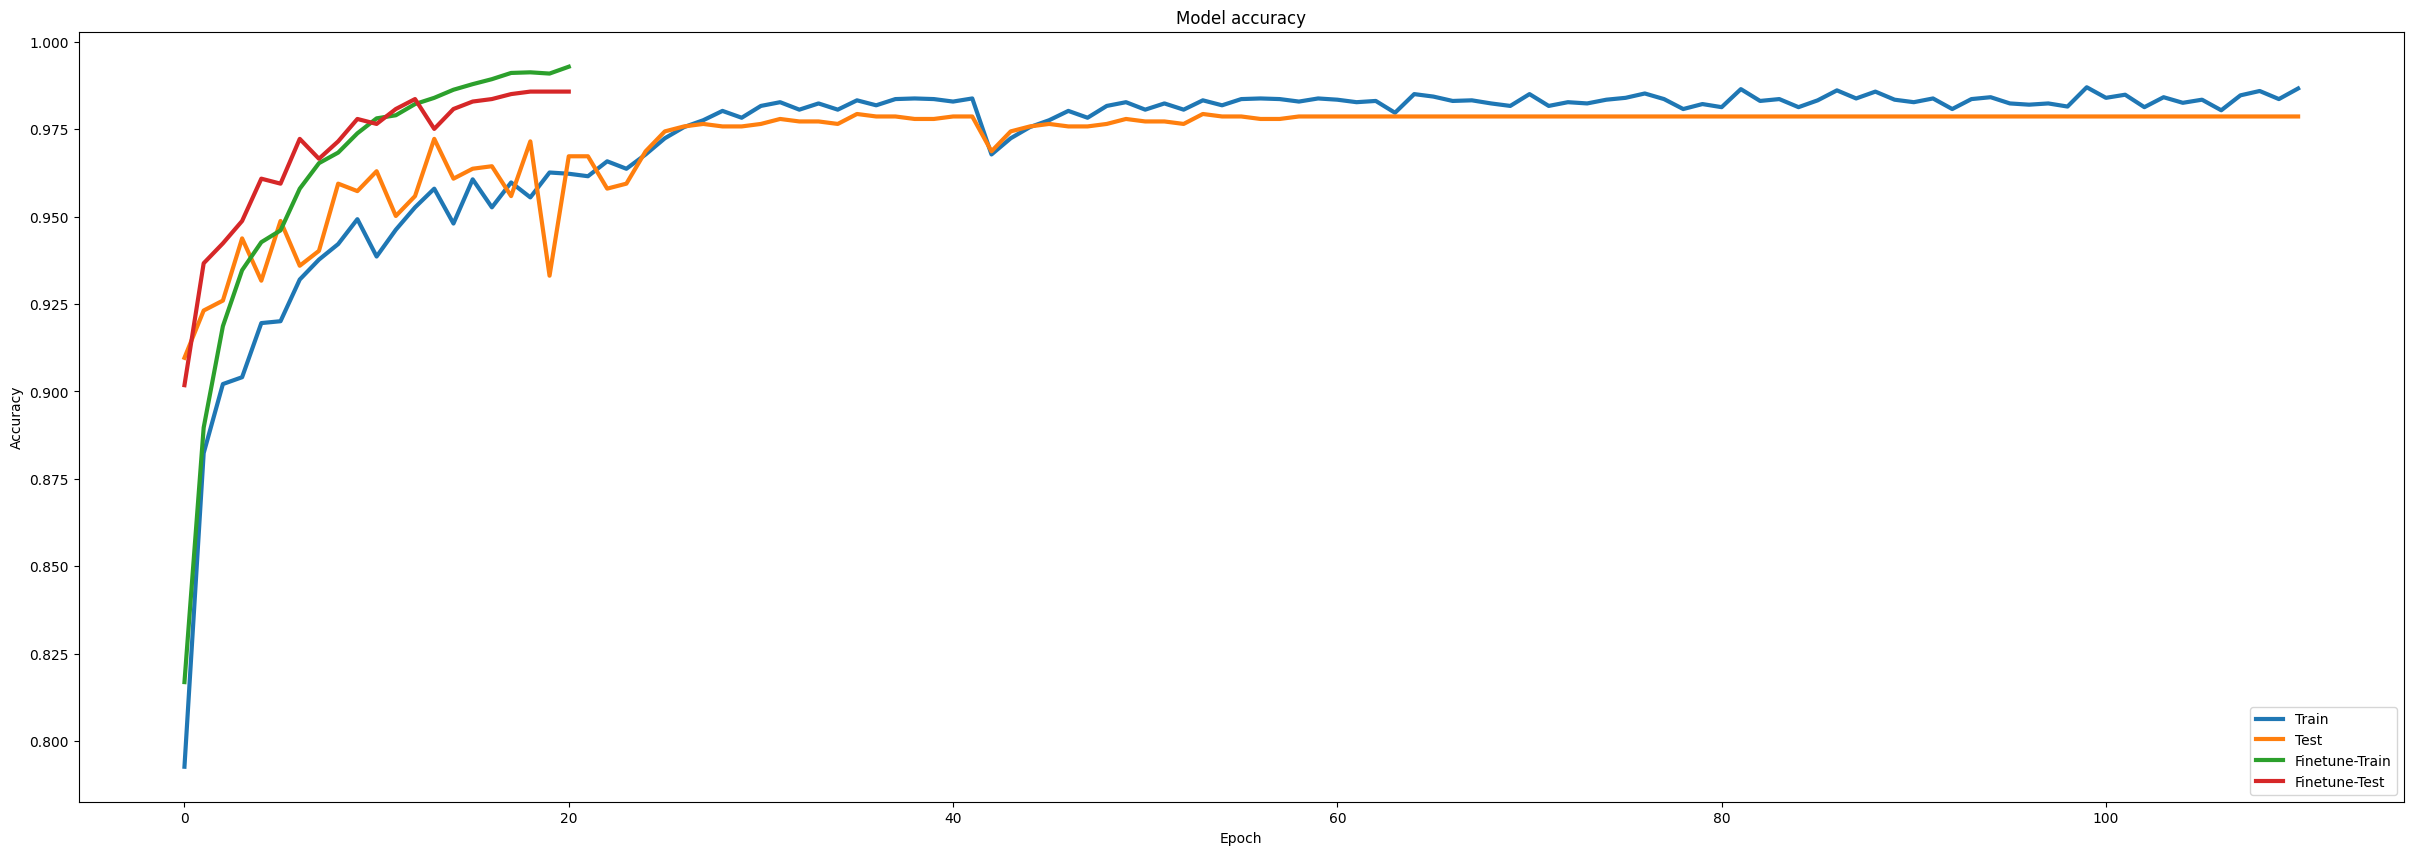

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.plot(np.array(fh['accuracy']), linewidth=3)
plt.plot(np.array(fh['val_accuracy']), linewidth=3)
plt.plot(np.array(h3['accuracy']), linewidth=3)
plt.plot(np.array(h3['val_accuracy']), linewidth=3)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test','Finetune-Train', 'Finetune-Test'], loc='lower right')
plt.show()

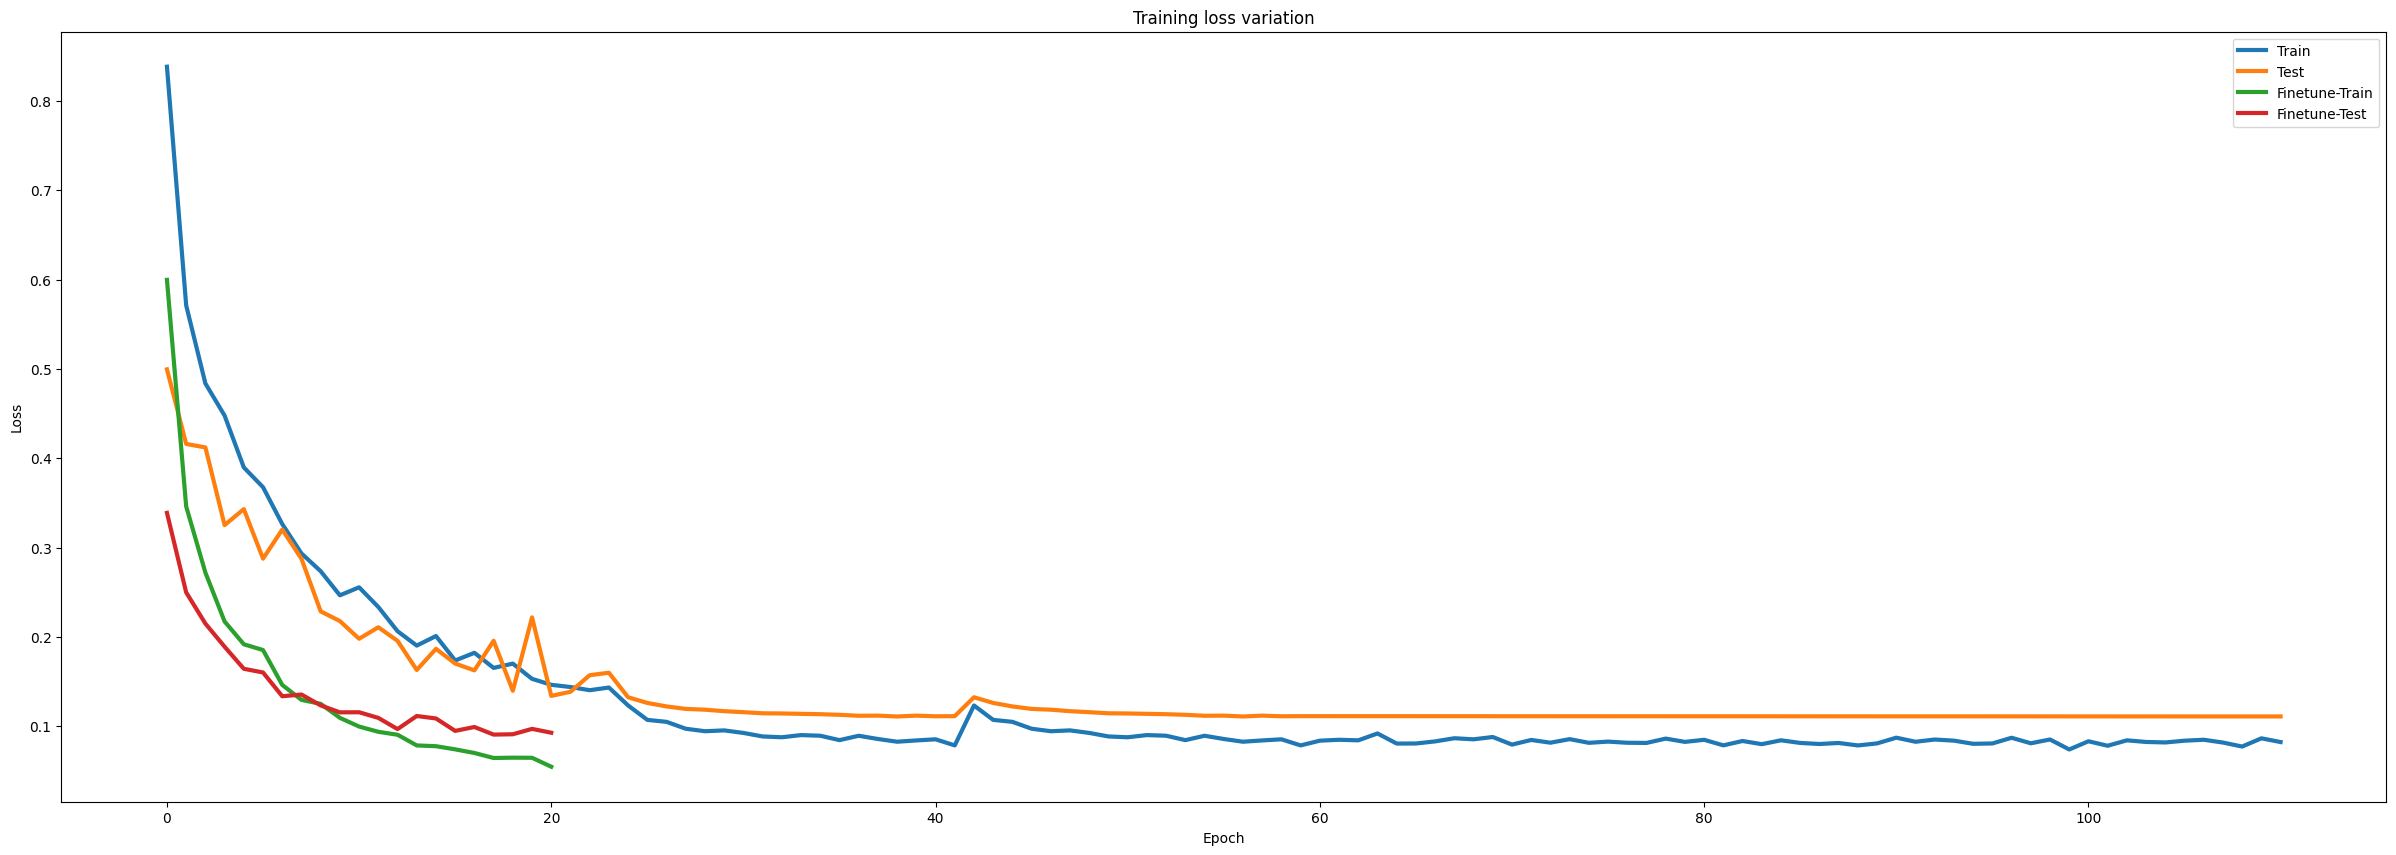

In [45]:
plt.figure(figsize=(30,10))
plt.plot(np.array(fh["loss"]), linewidth=3)
plt.plot(np.array(fh["val_loss"]), linewidth=3)
plt.plot(np.array(h3["loss"]), linewidth=3)
plt.plot(np.array(h3["val_loss"]), linewidth=3)
plt.title('Training loss variation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test','Finetune-Train', 'Finetune-Test' ], loc='upper right')
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Test Accuracy: 98.77%


---- Test Results ----
1 .
[1.0000000e+00 8.4700727e-12 4.2978865e-09 2.7239682e-09]


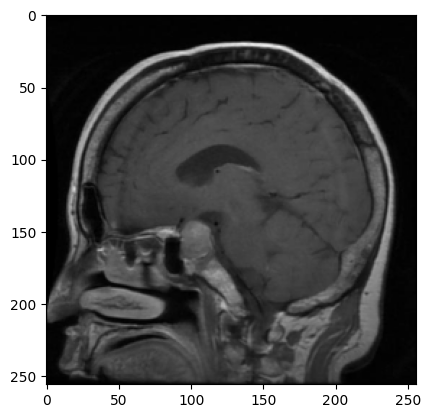

Actual: pituitary
Predicted: pituitary
Confidence: 100.0%
2 .
[9.9998260e-01 3.5419305e-06 9.0919584e-06 4.7985695e-06]


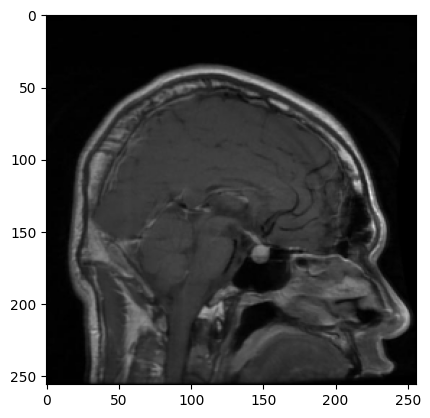

Actual: pituitary
Predicted: pituitary
Confidence: 99.9983%
3 .
[8.3856406e-09 6.5599446e-09 2.3361526e-06 9.9999762e-01]


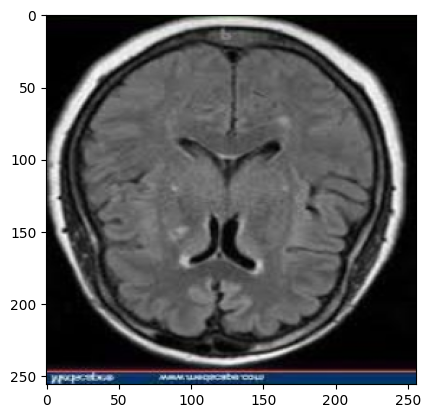

Actual: healthy
Predicted: healthy
Confidence: 99.9998%
4 .
[9.9999976e-01 8.7428659e-10 2.6900895e-07 7.8063405e-09]


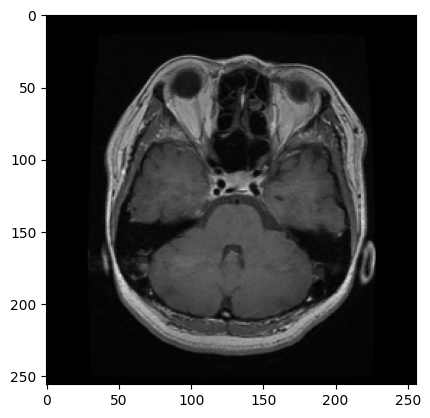

Actual: pituitary
Predicted: pituitary
Confidence: 100.0%
5 .
[9.9999452e-01 3.2705088e-07 4.2409979e-06 8.2856280e-07]


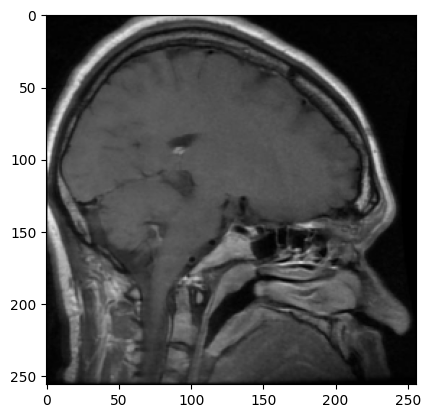

Actual: pituitary
Predicted: pituitary
Confidence: 99.9995%
6 .
[1.4878597e-07 1.4339418e-04 9.9985647e-01 2.3621238e-08]


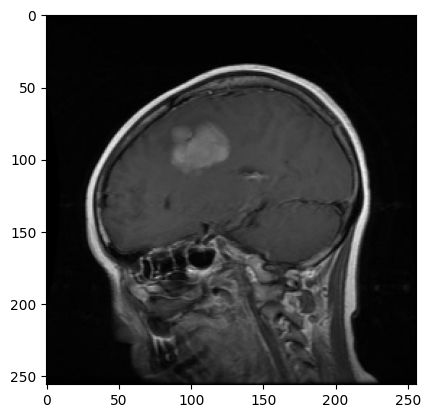

Actual: meningioma
Predicted: meningioma
Confidence: 99.9856%
7 .
[7.9796694e-09 3.3041533e-07 1.0914980e-04 9.9989045e-01]


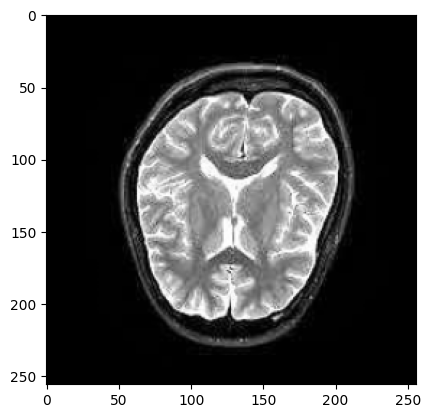

Actual: healthy
Predicted: healthy
Confidence: 99.989%
8 .
[7.832891e-09 1.000000e+00 4.701140e-09 4.083574e-08]


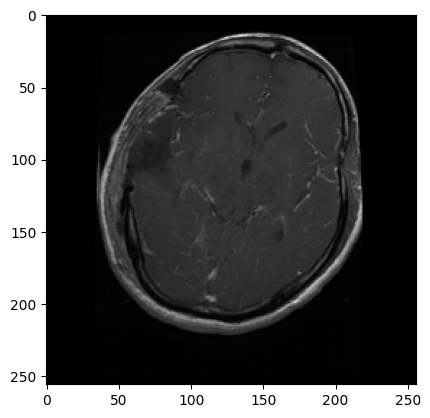

Actual: glioma
Predicted: glioma
Confidence: 100.0%
9 .
[1.0000000e+00 5.8467502e-12 3.6134290e-10 5.0992783e-11]


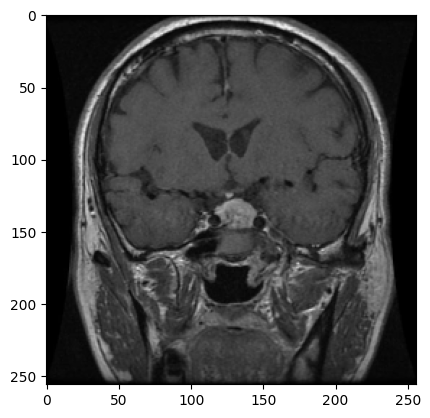

Actual: pituitary
Predicted: pituitary
Confidence: 100.0%
10 .
[2.3399687e-09 1.9819777e-09 1.2804772e-06 9.9999869e-01]


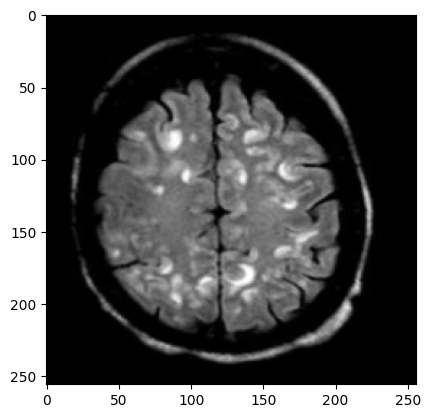

Actual: healthy
Predicted: healthy
Confidence: 99.9999%
11 .
[3.1819571e-09 4.6374865e-10 6.1658533e-08 9.9999988e-01]


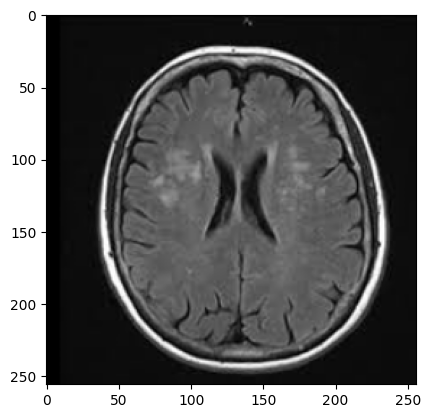

Actual: healthy
Predicted: healthy
Confidence: 100.0%
12 .
[6.5296014e-08 2.0236192e-10 4.4877311e-07 9.9999952e-01]


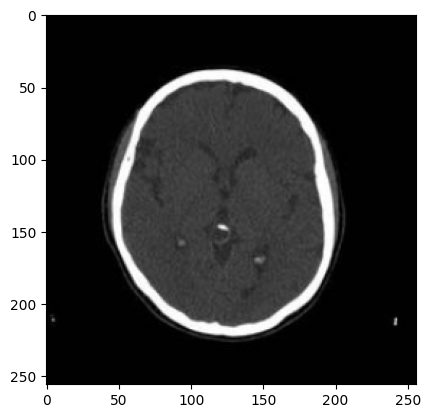

Actual: healthy
Predicted: healthy
Confidence: 100.0%
13 .
[1.0311984e-05 1.6465558e-05 9.9913681e-01 8.3628774e-04]


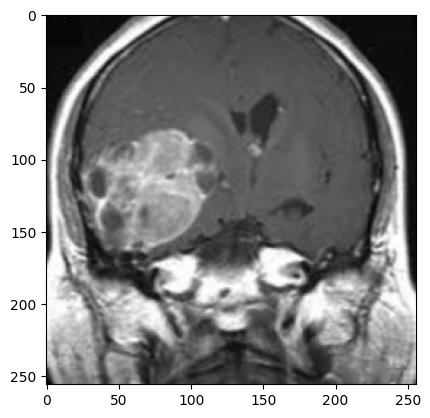

Actual: meningioma
Predicted: meningioma
Confidence: 99.9137%
14 .
[4.2289068e-11 9.9703765e-01 2.9623401e-03 6.2728072e-09]


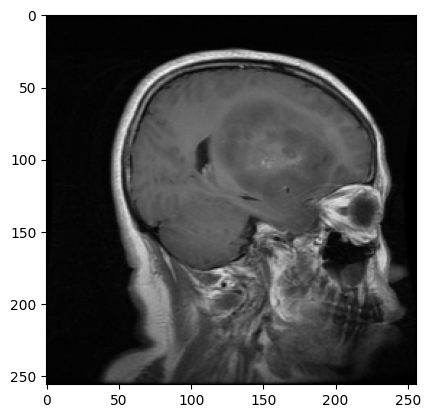

Actual: glioma
Predicted: glioma
Confidence: 99.7038%
15 .
[2.9740818e-06 4.9265102e-02 9.5073158e-01 3.7459219e-07]


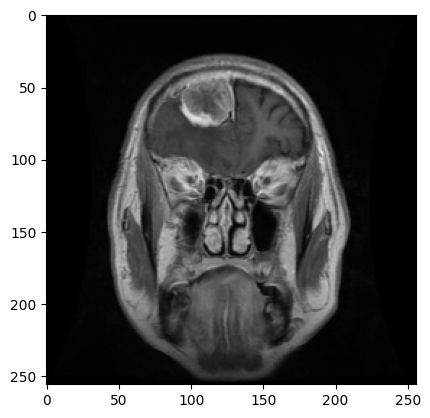

Actual: meningioma
Predicted: meningioma
Confidence: 95.0732%


In [70]:
y_pred = model.predict(np.array(X_test))
y_pred_classes = np.argmax(y_pred, axis=1)

test_accuracy = np.sum(y_pred_classes == np.array([labels_dict[i] for i in y_test])) / len(y_test)
print(f"Test Accuracy: {round(test_accuracy*100, 2)}%")
print('''
''')
print("---- Test Results ----")
for i in range(15):
    print(i+1,".")
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    print(y_pred[i])
    plt.show()
    print(f"Actual: {list(labels_dict.keys())[y_pred_classes[i]]}")
    print(f"Predicted: {y_test[i]}")
    print(f"Confidence: {round(y_pred[i][y_pred_classes[i]]*100, 4)}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


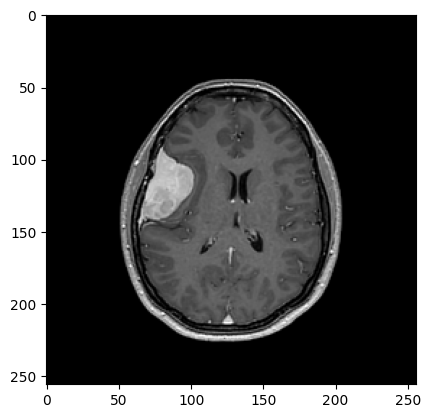

Prediction: meningioma
[[7.4037891e-09 3.9165167e-07 9.9999952e-01 5.4543335e-08]]
Confidence: 100.0%


In [67]:
img = cv2.imread(r"/kaggle/input/meningioma-picture/9b3c24072a2568610b99707aa719ce850ac5b3ac515d6abb3692649109cf19e9_big_gallery-2.jpeg")
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
prediction = model.predict(np.array([img]))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print(f"Prediction: {ld[np.argmax(prediction)]}")
print(prediction)
print(f"Confidence: {round(max(prediction[0])*100, 2)}%")